<a href="https://colab.research.google.com/github/shipleydm/IS8036_PROJECT/blob/main/IS8036PostErrorDiscovery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Python Packages

In [2]:
%%capture
!pip install verstack
!pip install tensorflow

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sklearn
import tensorflow as tf

import lightgbm as lgb
from lightgbm import LGBMModel
import xgboost as xgb
from xgboost import XGBRegressor

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import ensemble
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn import neighbors
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from math import sqrt
from sklearn.metrics import r2_score
# from sklearn.utils import parallel
from yellowbrick.regressor import residuals_plot
from yellowbrick.regressor import prediction_error
from verstack import LGBMTuner
from sklearn.metrics import mean_absolute_error
import pprint

from keras.layers import Dense , Dropout
from keras.models import Sequential
from keras.optimizers import SGD , Adam
from keras.callbacks import EarlyStopping



import scipy
from scipy.sparse import hstack

from google.colab import drive

Bringing Data In

In [4]:
drive.mount('/content/drive')

# dir = '/content/drive/My Drive/IS8036/AirBnB/DatCleanData'

dir = '/content/drive/MyDrive/IS8036/AirBnB/DatCleanData'

listing_data=pd.read_csv(dir+'/CLEANLISTINGS.csv')
# review_data=pd.read_csv(dir+'/reviews.csv')
# neighborhood_data=pd.read_csv(dir+'/neighbourhoods.csv')

Mounted at /content/drive


In [65]:
plt.style.use('seaborn-white')

In [6]:
listing_data.head(5)

,intListingID,strListingURL,boolInstantlyBookable,boolGuestProfilePicReqToBook,boolVerifiedGuestPhoneReqToBook,dtListingLastScraped,dtListingBookingCalendarLastScraped,dtListingFirstReview,intDaysSinceFirstReview,dtListingLastReview,...,boolHasAirConditioning,boolHasKitchen,boolHasHotWater,boolGuestPetsAllowed,boolHasTV,boolHasPool,boolHasHotTub,boolHasEVCharger,boolHasCable,boolHasInternet
0,10185917,https://www.airbnb.com/rooms/10185917,0,0,0,2020-05-31,2020-05-31,NaN,NaN,NaN,...,0,1,0,0,1,0,0,0,0,1
1,10681596,https://www.airbnb.com/rooms/10681596,0,0,0,2020-05-31,2020-05-31,NaN,NaN,NaN,...,0,1,0,0,1,0,0,0,1,1
2,10886705,https://www.airbnb.com/rooms/10886705,0,0,0,2020-05-31,2020-05-31,NaN,NaN,NaN,...,1,1,0,0,1,1,0,0,0,1
3,11023946,https://www.airbnb.com/rooms/11023946,0,0,0,2020-05-30,2020-05-30,NaN,NaN,NaN,...,1,1,0,0,1,0,0,0,0,1
4,43160258,https://www.airbnb.com/rooms/43160258,1,0,0,2020-05-31,2020-05-31,NaN,NaN,NaN,...,0,1,0,0,1,0,0,0,0,1


In [7]:
listing_data.dtypes

intListingID                        int64
strListingURL                      object
boolInstantlyBookable               int64
boolGuestProfilePicReqToBook        int64
boolVerifiedGuestPhoneReqToBook     int64
                                    ...  
boolHasPool                         int64
boolHasHotTub                       int64
boolHasEVCharger                    int64
boolHasCable                        int64
boolHasInternet                     int64
Length: 163, dtype: object

id

listing_url

scrape_id

last_scraped

name

summary

space

description

experiences_offered

neighborhood_overview

notes

transit

access

interaction

house_rules

thumbnail_url

medium_url

picture_url

xl_picture_url

host_id

host_url

host_name

host_since

host_location

host_about

host_response_time

host_response_rate

host_acceptance_rate

host_is_superhost

host_thumbnail_url

host_picture_url

host_neighbourhood

host_listings_count

host_total_listings_count

host_verifications

host_has_profile_pic

host_identity_verified

street

neighbourhood

neighbourhood_cleansed

neighbourhood_group_cleansed

city

state

zipcode

market

smart_location

country_code

country

latitude

longitude

is_location_exact

property_type

room_type

accommodates

bathrooms

bedrooms

beds

bed_type

amenities

square_feet

price

weekly_price

monthly_price

security_deposit

cleaning_fee

guests_included

extra_people

minimum_nights

maximum_nights

minimum_minimum_nights

maximum_minimum_nights

minimum_maximum_nights

maximum_maximum_nights

minimum_nights_avg_ntm

maximum_nights_avg_ntm

calendar_updated

has_availability

availability_30

availability_60

availability_90

availability_365

calendar_last_scraped

number_of_reviews

number_of_reviews_ltm

first_review

last_review

review_scores_rating

review_scores_accuracy

review_scores_cleanliness

review_scores_checkin

review_scores_communication

review_scores_location

review_scores_value

requires_license

license

jurisdiction_names

instant_bookable

is_business_travel_ready

cancellation_policy

require_guest_profile_picture

require_guest_phone_verification

calculated_host_listings_count

calculated_host_listings_count_entire_homes

calculated_host_listings_count_private_rooms

calculated_host_listings_count_shared_rooms

reviews_per_month

## Narrowing Down Predictors and Exploring

In [8]:
# reading the csv file using read_csv
# storing the data frame in variable called df
df = pd.read_csv(dir+'/KeepingColumns.csv', encoding="ISO-8859-1")
 
# creating a list of column names by
# calling the .columns
list_of_columns_to_keep = list(df.columns)
 
# displaying the list of column names
# print(list_of_columns_to_keep)

In [9]:
listing_df = listing_data.loc[:, list_of_columns_to_keep]
listing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7221 entries, 0 to 7220
Data columns (total 93 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   boolInstantlyBookable                        7221 non-null   int64  
 1   boolGuestProfilePicReqToBook                 7221 non-null   int64  
 2   boolVerifiedGuestPhoneReqToBook              7221 non-null   int64  
 3   intDaysSinceFirstReview                      5912 non-null   float64
 4   intDaysSinceLastReview                       5912 non-null   float64
 5   intDaysSinceLastBookingCalendarUpdate        7162 non-null   float64
 6   cintNeighborhood                             7221 non-null   int64  
 7   cintZipCode                                  7221 non-null   int64  
 8   cintPropertyType                             7221 non-null   int64  
 9   ointRoomType                                 7221 non-null   int64  
 10  

In [10]:
listing_df['intDailyPrice'].describe()

count    7221.000000
mean      154.432073
std       238.478479
min        10.000000
25%        60.000000
50%       100.000000
75%       175.000000
max      5500.000000
Name: intDailyPrice, dtype: float64

In [11]:
# Define the columns to drop and the target variable
# going ahead and removing this host info as well, not being used for predictors
remove_cols = ['strHostNeighborhood', 'strHostCity', 'strHostStateProv', 'strHostCountry']
for name in remove_cols:
  if name in list_of_columns_to_keep:
    list_of_columns_to_keep.remove(name)

# final dataset with columns kept
listing_df = listing_df.loc[:, list_of_columns_to_keep]

In [12]:
# log transform y
logdf = listing_df
listing_df.intDailyPrice = np.log(listing_df.intDailyPrice)

In [13]:
listing_df.shape
print('There are 7221 rows & 89 Columns in the data set')

There are 7221 rows & 89 Columns in the data set


In [14]:
listing_df['intDailyPrice'].describe()

count    7221.000000
mean        4.669631
std         0.764326
min         2.302585
25%         4.094345
50%         4.605170
75%         5.164786
max         8.612503
Name: intDailyPrice, dtype: float64

In [15]:
# Split the data into training and test sets
df_train, df_test = train_test_split(logdf, test_size=0.2, random_state=41)

df_train.shape

# double check to bring in correct column types
col = df_train.select_dtypes(['float64', 'int', 'int64']).columns

Text(0.5, 1.0, 'Correlation matrix of numerical features')

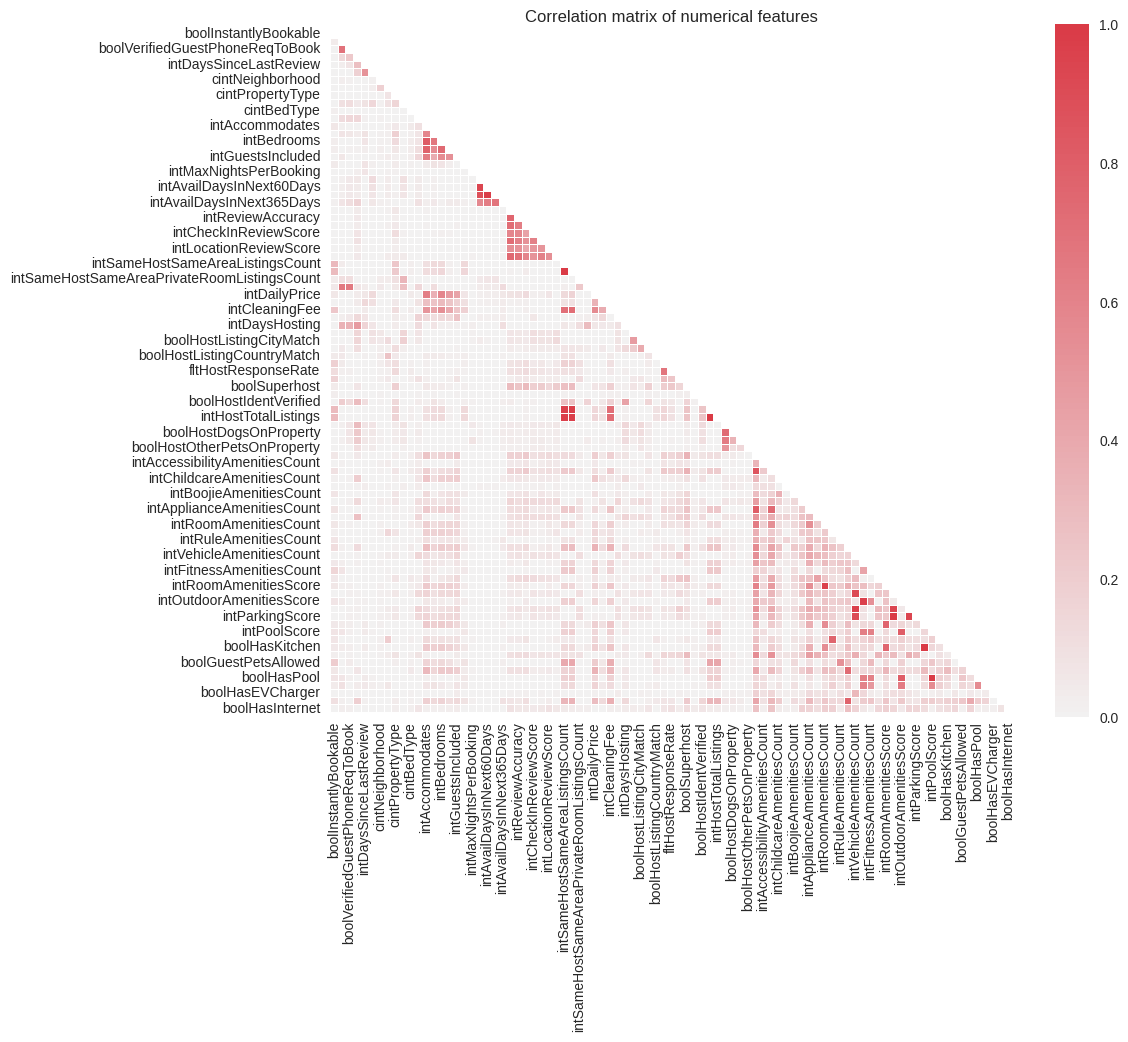

In [16]:
# correlation matrix
corr = df_train.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, vmin=0, vmax=1.0, square=True, linewidths=.5, cbar_kws={"shrink": 1.0});
plt.title('Correlation matrix of numerical features')

In [17]:
# select upper traingle of correlation matrix
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))

# Find index of columns with correlation greater than cutoff
to_drop = [column for column in upper.columns if any(upper[column] > 0.80)]
print(to_drop)
len(to_drop)

['intBedrooms', 'intAvailDaysInNext60Days', 'intAvailDaysInNext90Days', 'intSameHostSameAreaEntireHomeListingsCount', 'intHostListings', 'intHostTotalListings', 'intProvidedItemsAmenitiesCount', 'intApplianceAmenitiesCount', 'intRoomAmenitiesScore', 'intVehicleAmenitiesScore', 'intOutdoorAmenitiesScore', 'intParkingOptionsCount', 'intParkingScore', 'intPoolScore', 'boolHasKitchen', 'boolHasPool']


16

In [18]:
# correlated_features = set()
# correlation_matrix = corr
# for i in range(len(correlation_matrix .columns)):
#     for j in range(i):
#         if abs(correlation_matrix.iloc[i, j]) > 0.8:
#             colname = correlation_matrix.columns[i]
#             correlated_features.add(colname)

# print(correlated_features)
# len(correlated_features)

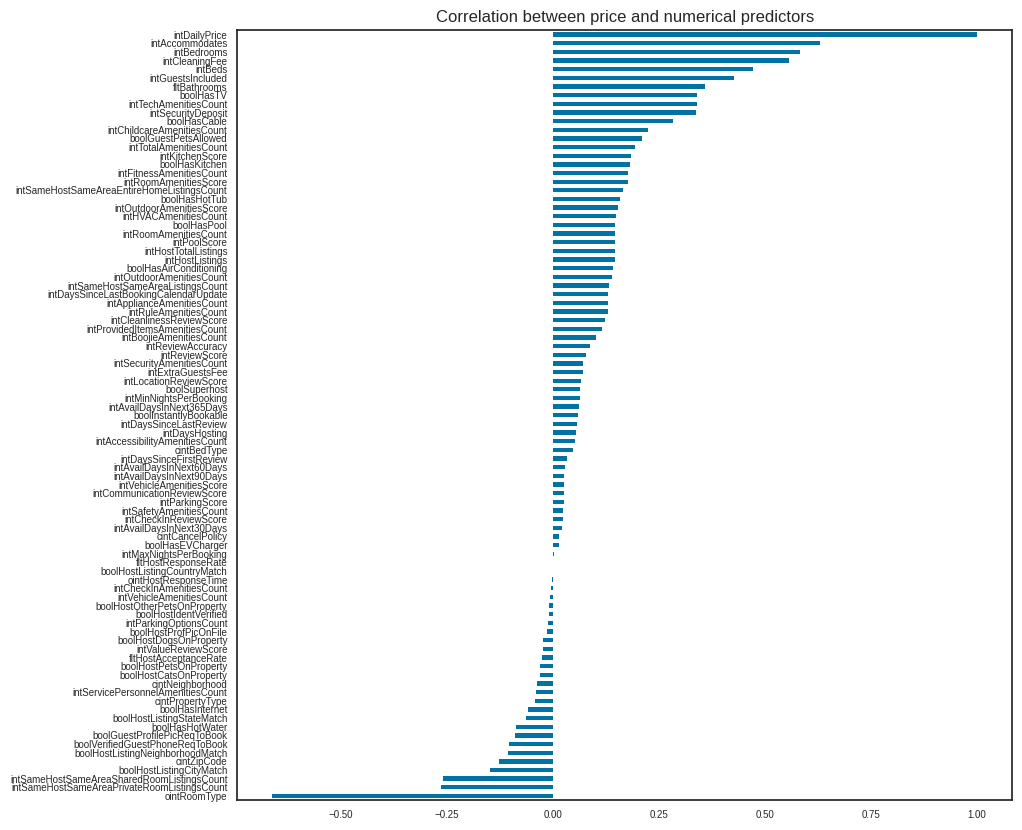

In [19]:
df_train[col].corr() ['intDailyPrice'].sort_values(ascending=True).dropna().plot(kind='barh', figsize=(10,10));
plt.title('Correlation between price and numerical predictors');
plt.tick_params(labelsize=7)
plt.grid(False, which='major')

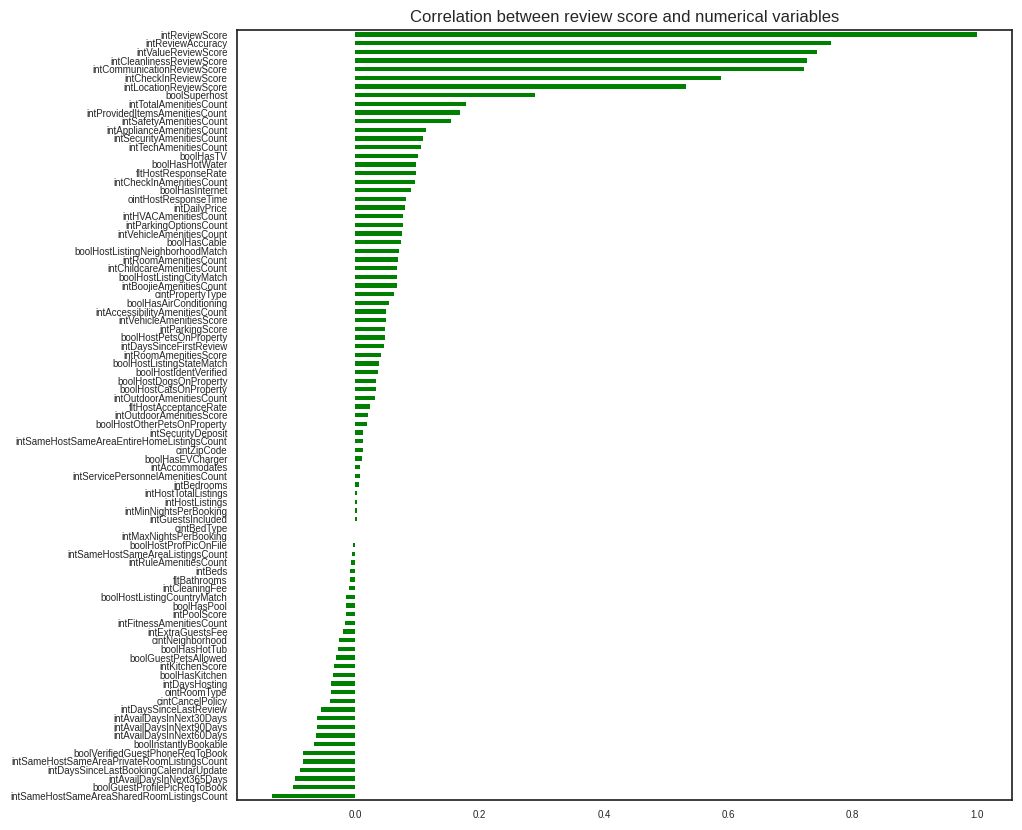

In [20]:
# below is just out of curiosity
df_train[col].corr() ['intReviewScore'].sort_values(ascending=True).dropna().plot(kind='barh', figsize=(10,10), color='green');
plt.title('Correlation between review score and numerical variables');
plt.tick_params(labelsize=7)
plt.grid(False, which='major')

Drop highly correlated variables

In [21]:
# select upper traingle of correlation matrix
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))

# Find index of columns with correlation greater than cutoff
correlated_features = [column for column in upper.columns if any(upper[column] > 0.70)]
print(correlated_features)
len(correlated_features)

# drop the columns
df_train.drop(labels=correlated_features, axis=1, inplace=True)
df_test.drop(labels=correlated_features, axis=1, inplace=True)

['intBedrooms', 'intBeds', 'intAvailDaysInNext60Days', 'intAvailDaysInNext90Days', 'intReviewAccuracy', 'intCleanlinessReviewScore', 'intCommunicationReviewScore', 'intValueReviewScore', 'intSameHostSameAreaEntireHomeListingsCount', 'intCleaningFee', 'intHostListings', 'intHostTotalListings', 'boolHostDogsOnProperty', 'intProvidedItemsAmenitiesCount', 'intApplianceAmenitiesCount', 'intRoomAmenitiesScore', 'intVehicleAmenitiesScore', 'intOutdoorAmenitiesScore', 'intParkingOptionsCount', 'intParkingScore', 'intKitchenScore', 'intPoolScore', 'boolHasAirConditioning', 'boolHasKitchen', 'boolHasTV', 'boolHasPool', 'boolHasCable']


In [22]:
# double check to bring in correct column types
col = df_train.select_dtypes(['float64', 'int', 'int64']).columns

## Light GBM Model

In [23]:
def model_eval(X_train, y_train, X_test, y_test, model):
    '''
    input: X is features data frame, y is response, model
    output: train cross validation score, test score, predicted values
    
    '''
    model.fit(X_train, np.ravel(y_train))
    y_train_pred = model.predict(X_train)
    y_pred = model.predict(X_test)
    score = cross_val_score(model, X_train, y_train, scoring = 'r2', cv = 5)        # Array of R^2 scores of the estimator for each run of the cross validation.
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_rmse = train_mse**(0.5)
    test_mse = mean_squared_error(y_test, y_pred)
    test_rmse = test_mse**(0.5)
    train_score = r2_score(y_train, y_train_pred)  
    test_score = r2_score(y_test, y_pred)                                           # R^2 (coefficient of determination) regression score function.            
    return score, train_score, test_score, train_rmse, test_rmse, y_pred

def plot_features(X, model, name):
    '''
    plot features importance of algoritm
    input: dataframe X and regression model
    output: Feature importance plot
    '''
    print("Plot feature importances…")
    headers = ["name", "score"]
    values = sorted(zip(X.columns, model.feature_importances_), key=lambda x: x[1] * -1)
    forest_feature_importances = pd.DataFrame(values, columns = headers)
    forest_feature_importances = forest_feature_importances.sort_values(by = ['score'], ascending = False)
    features = forest_feature_importances['name'][:25]
    y_pos = np.arange(len(features))
    scores = forest_feature_importances['score'][:25]
    #plot feature importances
    plt.figure(figsize=(13,8))
    plt.barh(y_pos, scores, align='center', alpha=0.5, color='red')
    plt.yticks(y_pos, features, rotation=0)   
    plt.ylabel('Features')
    plt.xlabel('Score')
    plt.title('Feature importances ' + name)
    plt.show()

In [24]:
exc =  ['intDailyPrice']

col = [i for i in col if i not in exc]
print('Number of columns is:', len(col))
print(col)

X = df_train[col]
X_test = df_test[col]
Y = df_train['intDailyPrice']
Y_test = df_test['intDailyPrice']

Number of columns is: 61
['boolInstantlyBookable', 'boolGuestProfilePicReqToBook', 'boolVerifiedGuestPhoneReqToBook', 'intDaysSinceFirstReview', 'intDaysSinceLastReview', 'intDaysSinceLastBookingCalendarUpdate', 'cintNeighborhood', 'cintZipCode', 'cintPropertyType', 'ointRoomType', 'cintBedType', 'cintCancelPolicy', 'intAccommodates', 'fltBathrooms', 'intGuestsIncluded', 'intMinNightsPerBooking', 'intMaxNightsPerBooking', 'intAvailDaysInNext30Days', 'intAvailDaysInNext365Days', 'intReviewScore', 'intCheckInReviewScore', 'intLocationReviewScore', 'intSameHostSameAreaListingsCount', 'intSameHostSameAreaPrivateRoomListingsCount', 'intSameHostSameAreaSharedRoomListingsCount', 'intSecurityDeposit', 'intExtraGuestsFee', 'intDaysHosting', 'boolHostListingNeighborhoodMatch', 'boolHostListingCityMatch', 'boolHostListingStateMatch', 'boolHostListingCountryMatch', 'ointHostResponseTime', 'fltHostResponseRate', 'fltHostAcceptanceRate', 'boolSuperhost', 'boolHostProfPicOnFile', 'boolHostIdentVerifi

In [61]:
model_lgb = lgb.LGBMRegressor(boosting_type ='gbdt', learning_rate = 0.1, num_leaves=31, max_depth =8) 
score, train_score, test_score, train_rmse, test_rmse, y_pred_lgbm = model_eval(X, Y, X_test, Y_test, model_lgb)

print('Number of columns is:', df_test.shape[1])
print('\n')
print('LGBM Model:')
print('- Mean of crossvalidation scores:', np.mean(score))
print("Training Results:")
print('- r2_score:', train_score)
print('- rmse:', train_rmse)
print("Testing Results:")
print('- r2_score:', test_score)
print('- rmse:', test_rmse)

Number of columns is: 62


LGBM Model:
- Mean of crossvalidation scores: 0.7494819203193813
Training Results:
- r2_score: 0.8825832544487553
- rmse: 0.2625501606515586
Testing Results:
- r2_score: 0.8002379766455985
- rmse: 0.33808112468040014


<Figure size 2200x2200 with 0 Axes>

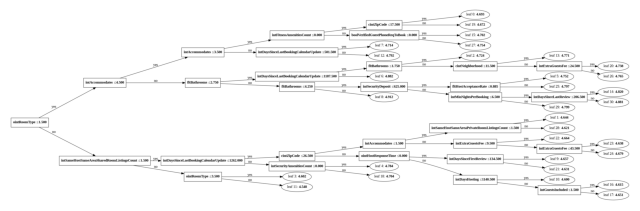

In [58]:
# visualize tree
plt.figure(figsize=(22,22))
lgb.plot_tree(model_lgb)
plt.savefig('lgbm_tree', dpi=300)

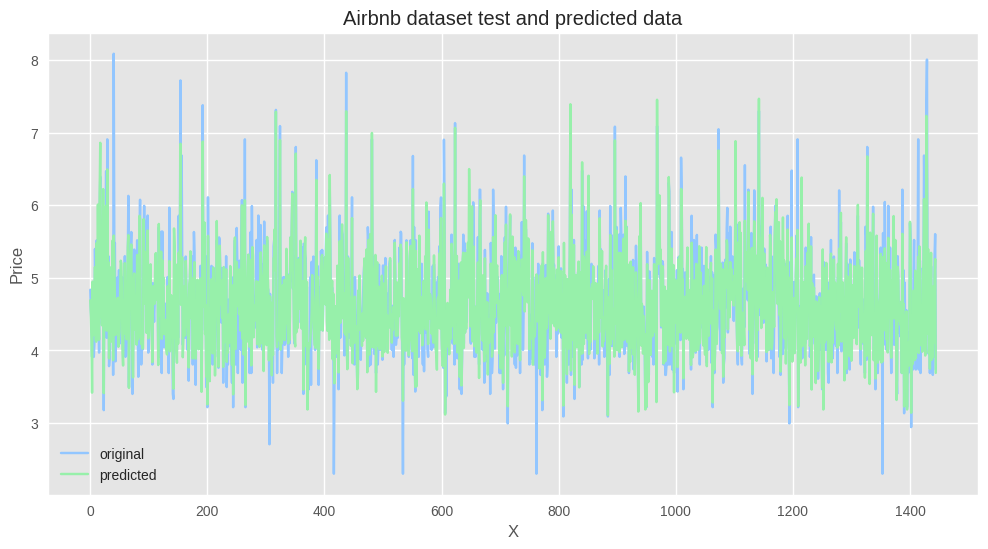

In [62]:
# visualizing in a plot
x_ax = range(len(Y_test))
plt.figure(figsize=(12, 6))
plt.plot(x_ax, Y_test, label="original")
plt.plot(x_ax, y_pred_lgbm, label="predicted")
plt.title("Airbnb dataset test and predicted data")
plt.xlabel('X')
plt.ylabel('Price')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()  

Plot feature importances…


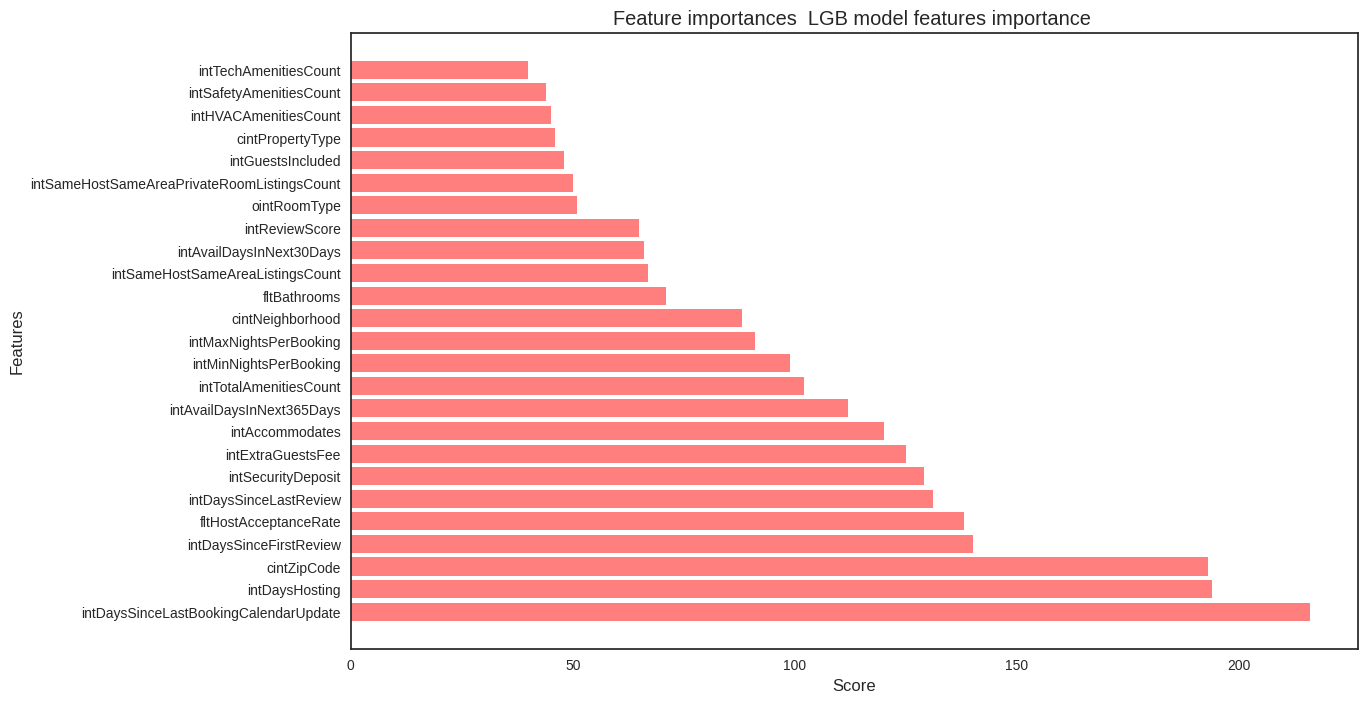

In [66]:
plot_features(X, model_lgb, " LGB model features importance ")

LGBM Basic Tune

In [27]:
#
# Trying different model eval method
#
# defining parameters 
params = {
    'task': 'train', 
    'boosting': 'gbdt',
    'objective': 'regression',
    'num_leaves': 31,
    'metric': {'l2','l1'},
    'verbose': -1
}
 

# loading data
lgb_train = lgb.Dataset(X, Y)
lgb_eval = lgb.Dataset(X_test, Y_test, reference=lgb_train)

# fitting the model
model = lgb.train(params,
                 train_set=lgb_train,
                 valid_sets=lgb_eval,
                 early_stopping_rounds=80)

[1]	valid_0's l2: 0.497765	valid_0's l1: 0.550499
Training until validation scores don't improve for 80 rounds
[2]	valid_0's l2: 0.436747	valid_0's l1: 0.512139
[3]	valid_0's l2: 0.387513	valid_0's l1: 0.479393
[4]	valid_0's l2: 0.346192	valid_0's l1: 0.450408
[5]	valid_0's l2: 0.312553	valid_0's l1: 0.425309
[6]	valid_0's l2: 0.28518	valid_0's l1: 0.403891
[7]	valid_0's l2: 0.263295	valid_0's l1: 0.385767
[8]	valid_0's l2: 0.244561	valid_0's l1: 0.369806
[9]	valid_0's l2: 0.228655	valid_0's l1: 0.355841
[10]	valid_0's l2: 0.215438	valid_0's l1: 0.344265
[11]	valid_0's l2: 0.204886	valid_0's l1: 0.334564
[12]	valid_0's l2: 0.195274	valid_0's l1: 0.325696
[13]	valid_0's l2: 0.187649	valid_0's l1: 0.318281
[14]	valid_0's l2: 0.180691	valid_0's l1: 0.311107
[15]	valid_0's l2: 0.17529	valid_0's l1: 0.305562
[16]	valid_0's l2: 0.169903	valid_0's l1: 0.300157
[17]	valid_0's l2: 0.164919	valid_0's l1: 0.29505
[18]	valid_0's l2: 0.160755	valid_0's l1: 0.290419
[19]	valid_0's l2: 0.157531	valid

In [28]:
# prediction
gbm_train_preds = model.predict(X)
gbm_test_preds = model.predict(X_test)

# accuracy check
r2_train = r2_score(Y, gbm_train_preds)
mse_train = mean_squared_error(Y, gbm_train_preds)
rmse_train = mse_train**(0.5)
print('Train data accuracy')
print("R2: %.4f" % r2_train)
print("MSE: %.4f" % mse_train)
print("RMSE: %.4f" % rmse_train) 

r2 = r2_score(Y_test, gbm_test_preds)
mse = mean_squared_error(Y_test, gbm_test_preds)
rmse = mse**(0.5)
print('Test data accuracy')
print("R2: %.4f" % r2)
print("MSE: %.4f" % mse)
print("RMSE: %.4f" % rmse) 

Train data accuracy
R2: 0.8890
MSE: 0.0652
RMSE: 0.2553
Test data accuracy
R2: 0.7972
MSE: 0.1161
RMSE: 0.3407


LGBM Optuna


 * Initiating LGBMTuner.fit
     . Settings:
     .. Trying 500 trials
     .. Evaluation metric: mse 
     .. Study direction: minimize mean_squared_error

     . Trial number: 0 finished
     .. Optimization score (lower-better): mean_squared_error: 0.12406458942434657
     .. Evaluation score (lower-better): mse: 0.12406458942434657
 ...........................................................................
     . Trial number: 1 finished
     .. Optimization score (lower-better): mean_squared_error: 0.15060161949366546
     .. Evaluation score (lower-better): mse: 0.15060161949366546
 ...........................................................................
     . Trial number: 2 finished
     .. Optimization score (lower-better): mean_squared_error: 0.16057890372873923
     .. Evaluation score (lower-better): mse: 0.16057890372873923
 ...........................................................................
     . Trial number: 3 finished
     .. Optimization score (lower-be

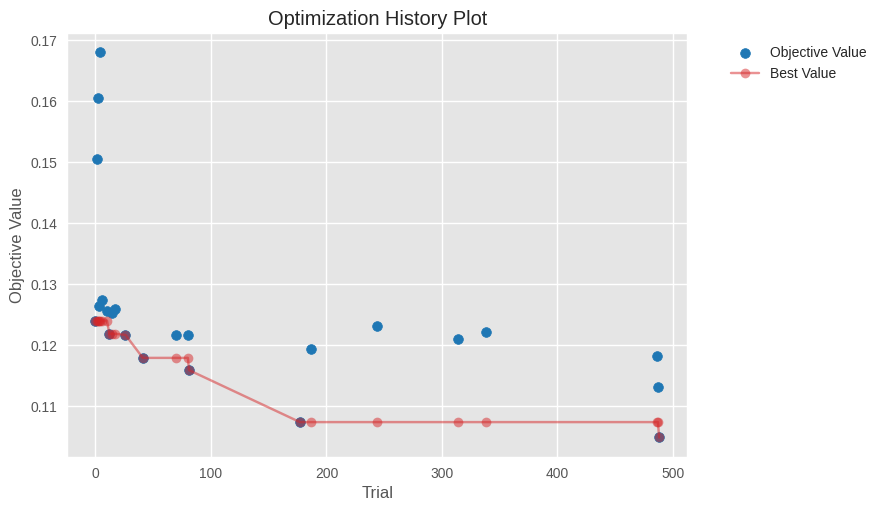

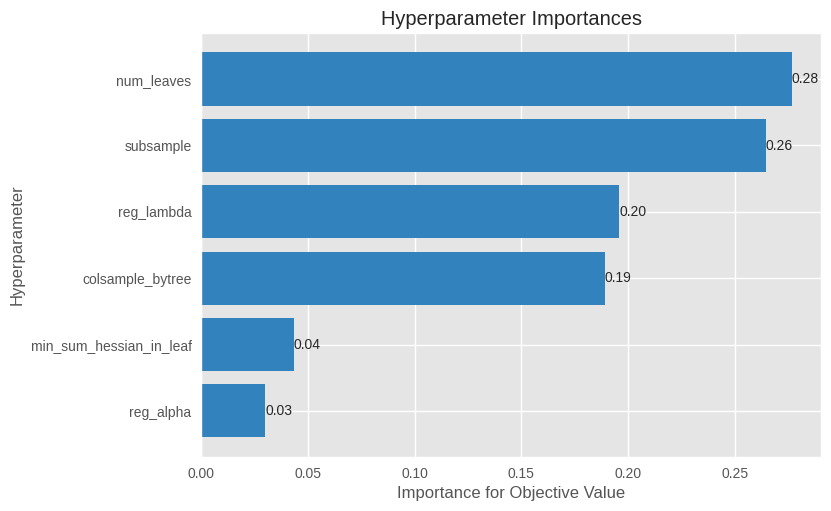

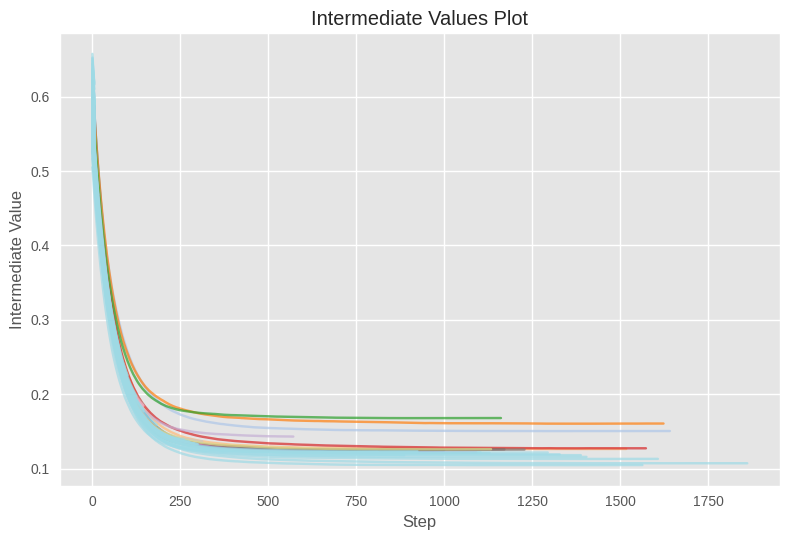

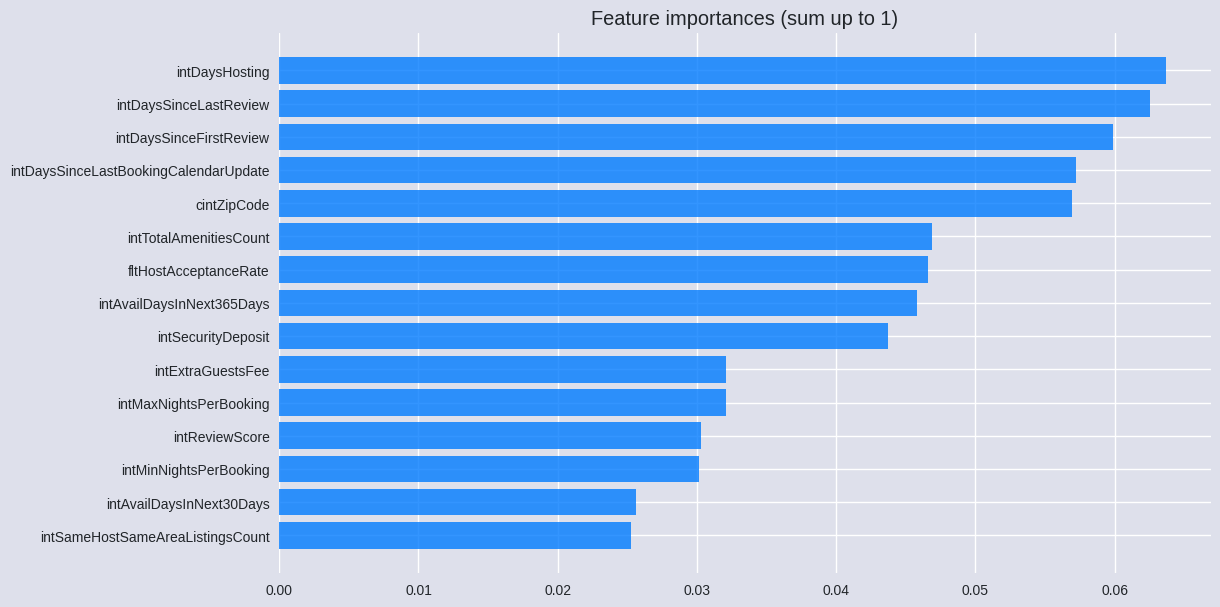


     . Optuna hyperparameters optimization finished
     .. Best trial number:488    |     mean_squared_error:          0.10489731654353418
 ---------------------------------------------------------------------------
     . n_estimators optimization finished
     .. best iteration: 1075   |     mse:           0.1496302976367455

Time elapsed for fit execution: 10 min 26.295 sec


In [29]:
# tune the hyperparameters and fit the optimized model
from verstack import LGBMTuner

tuner = LGBMTuner(metric = 'mse', trials = 500) # <- the only required argument
tuner.fit(X, Y)
# check the optimization log in the console.
# pred = tuner.predict(X_test)

In [30]:
# prediction
gbm_train_preds = tuner.predict(X)
gbm_test_preds = tuner.predict(X_test)

# accuracy check
r2_train = r2_score(Y, gbm_train_preds)
mse_train = mean_squared_error(Y, gbm_train_preds)
rmse_train = mse_train**(0.5)
print('Train data accuracy')
print("R2: %.4f" % r2_train)
print("MSE: %.4f" % mse_train)
print("RMSE: %.4f" % rmse_train) 

r2 = r2_score(Y_test, gbm_test_preds)
mse = mean_squared_error(Y_test, gbm_test_preds)
rmse = mse**(0.5)
print('Test data accuracy')
print("R2: %.4f" % r2)
print("MSE: %.4f" % mse)
print("RMSE: %.4f" % rmse) 

Train data accuracy
R2: 0.9718
MSE: 0.0166
RMSE: 0.1288
Test data accuracy
R2: 0.8137
MSE: 0.1066
RMSE: 0.3265


In [64]:
tuner.plot_importances(interactive = True)

Feature Importance Plot is saved to /content/FIM_DARK.html


## DNN

In [34]:
df_train_dnn = df_train.dropna()
df_test_dnn = df_test.dropna()

In [35]:
exc =  ['intDailyPrice']

col = [i for i in col if i not in exc]
print('Number of columns is:', len(col))
print(col)

x_train = df_train_dnn[col]
x_test = df_test_dnn[col]
y_train = df_train_dnn['intDailyPrice']
y_test = df_test_dnn['intDailyPrice']

# Normalize the inputs
mean = x_train.mean(axis=0)
std = x_train.std(axis=0)
x_train= (x_train - mean) / std
x_test = (x_test- mean) / std

Number of columns is: 61
['boolInstantlyBookable', 'boolGuestProfilePicReqToBook', 'boolVerifiedGuestPhoneReqToBook', 'intDaysSinceFirstReview', 'intDaysSinceLastReview', 'intDaysSinceLastBookingCalendarUpdate', 'cintNeighborhood', 'cintZipCode', 'cintPropertyType', 'ointRoomType', 'cintBedType', 'cintCancelPolicy', 'intAccommodates', 'fltBathrooms', 'intGuestsIncluded', 'intMinNightsPerBooking', 'intMaxNightsPerBooking', 'intAvailDaysInNext30Days', 'intAvailDaysInNext365Days', 'intReviewScore', 'intCheckInReviewScore', 'intLocationReviewScore', 'intSameHostSameAreaListingsCount', 'intSameHostSameAreaPrivateRoomListingsCount', 'intSameHostSameAreaSharedRoomListingsCount', 'intSecurityDeposit', 'intExtraGuestsFee', 'intDaysHosting', 'boolHostListingNeighborhoodMatch', 'boolHostListingCityMatch', 'boolHostListingStateMatch', 'boolHostListingCountryMatch', 'ointHostResponseTime', 'fltHostResponseRate', 'fltHostAcceptanceRate', 'boolSuperhost', 'boolHostProfPicOnFile', 'boolHostIdentVerifi

In [36]:
# Build the model
model = Sequential([
    Dense(64, activation='relu', input_shape=[x_train.shape[1]],kernel_initializer='he_normal',kernel_regularizer='l2',name='input'),
    Dropout(rate=0.4,name='drop1'),
    Dense(32, activation='relu',kernel_initializer='he_normal',kernel_regularizer='l2',name='dense1'),
    Dropout(rate=0.4,name='drop2'),
    Dense(1,name='output')
])

# Compile the model
OPTIMIZER=Adam(learning_rate=3e-4)
model.compile(optimizer=OPTIMIZER, loss='mean_squared_error')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Dense)               (None, 64)                3968      
                                                                 
 drop1 (Dropout)             (None, 64)                0         
                                                                 
 dense1 (Dense)              (None, 32)                2080      
                                                                 
 drop2 (Dropout)             (None, 32)                0         
                                                                 
 output (Dense)              (None, 1)                 33        
                                                                 
Total params: 6,081
Trainable params: 6,081
Non-trainable params: 0
_________________________________________________________________


In [37]:
# patient early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)

# Train the model
history = model.fit(x_train,y_train, epochs=1000, batch_size=64, validation_data=(x_test, y_test), callbacks=[es])

# Evaluate the model
test_loss = model.evaluate(x_test, y_test)
print('Test loss:', test_loss)

Epoch 1/1000
51/51 [==============================] - 2s 14ms/step - loss: 18.1460 - val_loss: 9.8930
Epoch 2/1000
51/51 [==============================] - 0s 4ms/step - loss: 10.9766 - val_loss: 5.9920
Epoch 3/1000
51/51 [==============================] - 0s 5ms/step - loss: 8.6983 - val_loss: 4.6662
Epoch 4/1000
51/51 [==============================] - 0s 4ms/step - loss: 7.6053 - val_loss: 4.1111
Epoch 5/1000
51/51 [==============================] - 0s 4ms/step - loss: 7.1388 - val_loss: 4.0041
Epoch 6/1000
51/51 [==============================] - 0s 5ms/step - loss: 6.9063 - val_loss: 3.7522
Epoch 7/1000
51/51 [==============================] - 0s 5ms/step - loss: 6.5227 - val_loss: 3.6729
Epoch 8/1000
51/51 [==============================] - 0s 6ms/step - loss: 6.0070 - val_loss: 3.5700
Epoch 9/1000
51/51 [==============================] - 0s 5ms/step - loss: 6.1856 - val_loss: 3.5153
Epoch 10/1000
51/51 [==============================] - 0s 6ms/step - loss: 5.7612 - val_loss: 3.3

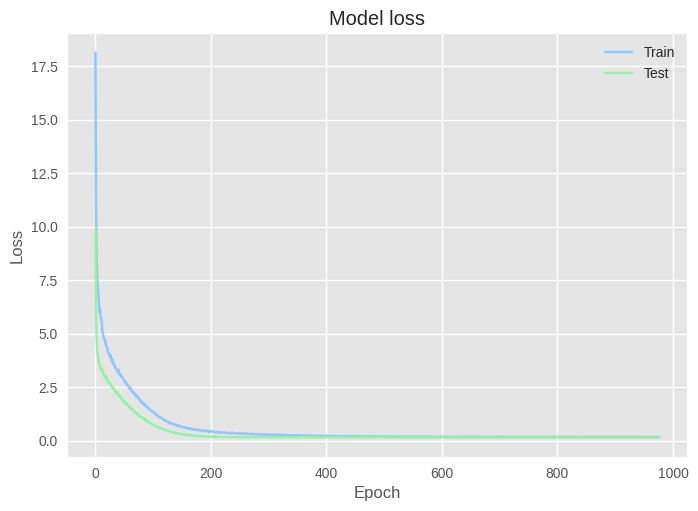

In [38]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [39]:
# prediction
dnn_train_preds = model.predict(x_train)
dnn_test_preds = model.predict(x_test)

# accuracy check
r2_train = r2_score(y_train, dnn_train_preds)
mse_train = mean_squared_error(y_train, dnn_train_preds)
rmse_train = mse_train**(0.5)
print('Train data accuracy')
print("R2: %.4f" % r2_train)
print("MSE: %.4f" % mse_train)
print("RMSE: %.4f" % rmse_train) 

r2 = r2_score(y_test, dnn_test_preds)
mse = mean_squared_error(y_test, dnn_test_preds)
rmse = mse**(0.5)
print('Test data accuracy')
print("R2: %.4f" % r2)
print("MSE: %.4f" % mse)
print("RMSE: %.4f" % rmse) 

26/26 [==============================] - 0s 1ms/step
Train data accuracy
R2: 0.8147
MSE: 0.1020
RMSE: 0.3194
Test data accuracy
R2: 0.7538
MSE: 0.1330
RMSE: 0.3647


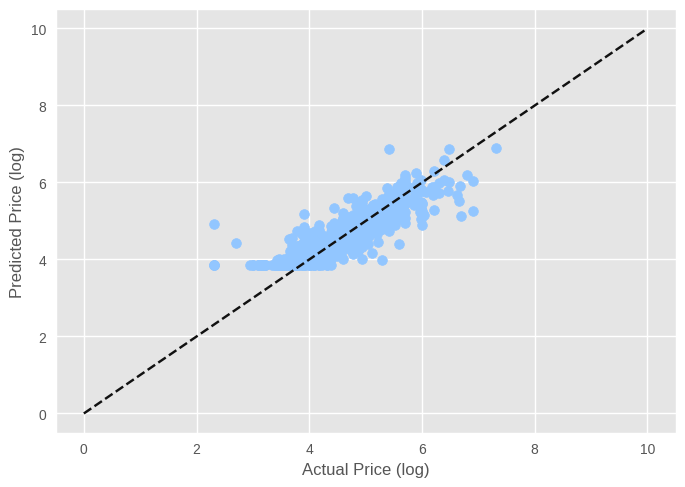

In [50]:
# Plot the actual vs predicted target values
plt.scatter(y_test, dnn_test_preds)
plt.plot([0, 10], [0, 10], '--k')
plt.xlabel('Actual Price (log)')
plt.ylabel('Predicted Price (log)')
plt.show()

## Random Forest Model

In [69]:
# drop nulls, can handle a different way if needed
df_train_rf = df_train.dropna()
df_test_rf = df_test.dropna()

In [70]:
# get data ready for model inputs
exc =  ['intDailyPrice']

col = [i for i in col if i not in exc]
print('Number of columns is:', len(col))
print(col)

X = df_train_rf[col]
X_test = df_test_rf[col]
Y = df_train_rf['intDailyPrice']
Y_test = df_test_rf['intDailyPrice']

Number of columns is: 61
['boolInstantlyBookable', 'boolGuestProfilePicReqToBook', 'boolVerifiedGuestPhoneReqToBook', 'intDaysSinceFirstReview', 'intDaysSinceLastReview', 'intDaysSinceLastBookingCalendarUpdate', 'cintNeighborhood', 'cintZipCode', 'cintPropertyType', 'ointRoomType', 'cintBedType', 'cintCancelPolicy', 'intAccommodates', 'fltBathrooms', 'intGuestsIncluded', 'intMinNightsPerBooking', 'intMaxNightsPerBooking', 'intAvailDaysInNext30Days', 'intAvailDaysInNext365Days', 'intReviewScore', 'intCheckInReviewScore', 'intLocationReviewScore', 'intSameHostSameAreaListingsCount', 'intSameHostSameAreaPrivateRoomListingsCount', 'intSameHostSameAreaSharedRoomListingsCount', 'intSecurityDeposit', 'intExtraGuestsFee', 'intDaysHosting', 'boolHostListingNeighborhoodMatch', 'boolHostListingCityMatch', 'boolHostListingStateMatch', 'boolHostListingCountryMatch', 'ointHostResponseTime', 'fltHostResponseRate', 'fltHostAcceptanceRate', 'boolSuperhost', 'boolHostProfPicOnFile', 'boolHostIdentVerifi

In [71]:
# model
rfm = RandomForestRegressor(n_estimators=30,                
                            #  criterion='mse' - mse is default. Options are: {'squared_error', 'friedman_mse', 'poisson', 'absolute_error'}
                            random_state=3, 
                            n_jobs=-1,
                            min_samples_leaf=3,
                            max_depth=5)
rfm.fit(X, Y)

RandomForestRegressor(max_depth=5, min_samples_leaf=3, n_estimators=30,
                      n_jobs=-1, random_state=3)

In [72]:
# prediction
rfm_train_preds = rfm.predict(X)
rfm_test_preds = rfm.predict(X_test)

# accuracy check
r2_train = r2_score(Y, rfm_train_preds)
mse_train = mean_squared_error(rfm_train_preds, Y)
rmse_train = sqrt(mean_squared_error(rfm_train_preds, Y))
print('Train data accuracy')
print("R2: %.4f" % r2_train)
print("MSE: %.4f" % mse_train)
print("RMSE: %.4f" % rmse_train) 

r2_test = r2_score(Y_test, rfm_test_preds)
mse_test = mean_squared_error(rfm_test_preds, Y_test)
rmse_test = sqrt(mean_squared_error(rfm_test_preds, Y_test))
print('Test data accuracy')
print("R2: %.4f" % r2_test)
print("MSE: %.4f" % mse_test)
print("RMSE: %.4f" % rmse_test) 

Train data accuracy
R2: 0.7718
MSE: 0.1256
RMSE: 0.3544
Test data accuracy
R2: 0.7436
MSE: 0.1385
RMSE: 0.3722


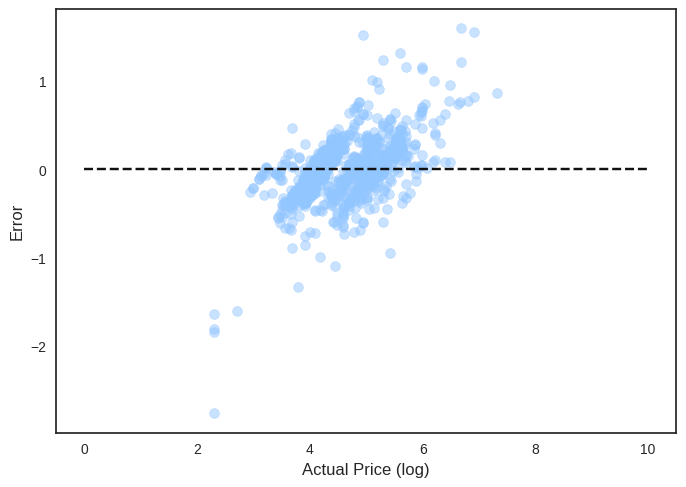

In [73]:
#Find Errors by calculating the difference between the actual and predicted values
Errors=Y_test-rfm_test_preds

#Scatter plot between the Actual values and Error term
plt.scatter(Y_test, Errors, alpha=0.5)
plt.plot([0, 10], [0, 0], '--k')
plt.xlabel('Actual Price (log)')
plt.ylabel('Error')
plt.show()
plt.show()

Plot feature importances…


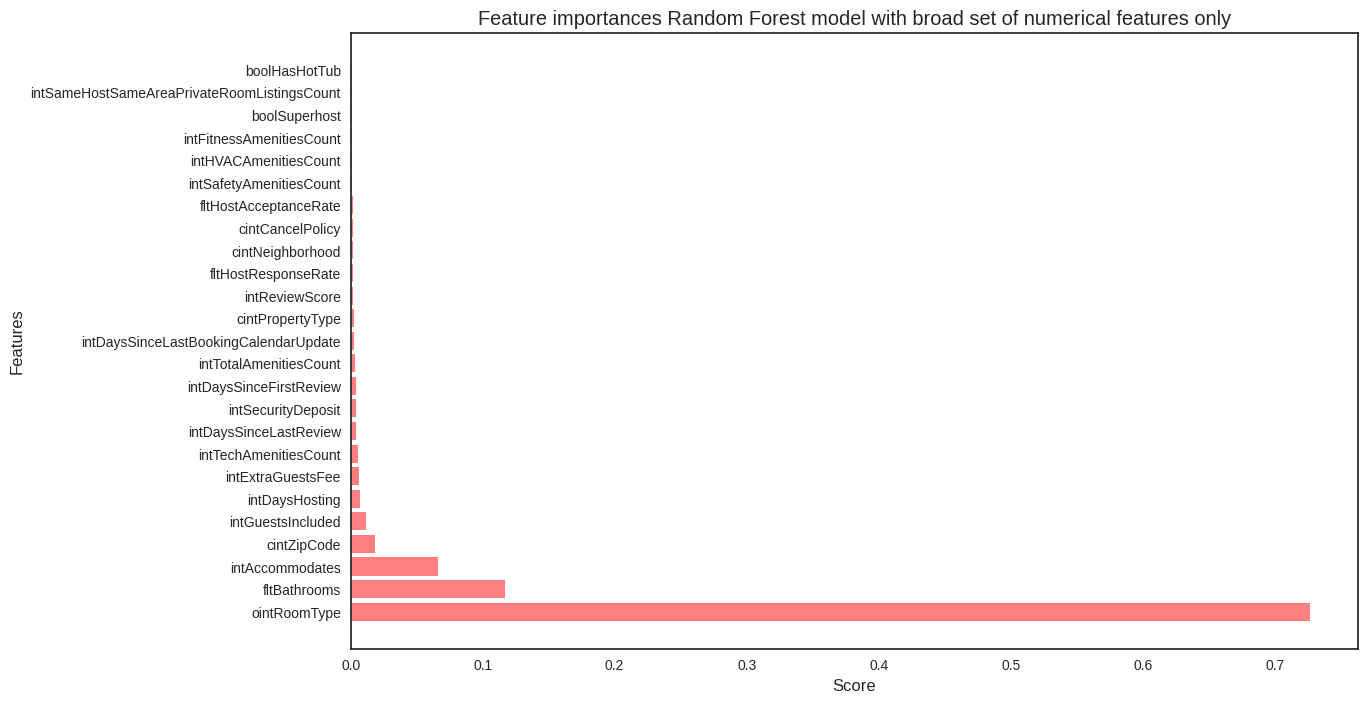

In [74]:
plot_features(X, rfm, "Random Forest model with broad set of numerical features only")

In [75]:
# keep highest importance values until we have the best result at the end
exc=  ['intAccommodates', 'ointRoomType', 'fltBathrooms','intGuestsIncluded', 'cintZipCode']

col1 = [i for i in col if i in exc]
print('Number of columns is:', len(col1))
print(col1)
X = df_train_rf[col1]
X_test = df_test_rf[col1]

# model - reduced
rfm_r = RandomForestRegressor(n_estimators=30,                
                            #  criterion='mse' - mse is default. Options are: {'squared_error', 'friedman_mse', 'poisson', 'absolute_error'}
                            random_state=3, 
                            n_jobs=-1,
                            min_samples_leaf=3,
                            max_depth=5)
rfm_r.fit(X, Y)

Number of columns is: 5
['cintZipCode', 'ointRoomType', 'intAccommodates', 'fltBathrooms', 'intGuestsIncluded']


RandomForestRegressor(max_depth=5, min_samples_leaf=3, n_estimators=30,
                      n_jobs=-1, random_state=3)

In [76]:
# prediction
rfm_train_preds = rfm_r.predict(X)
rfm_test_preds = rfm_r.predict(X_test)

# accuracy check
r2_train = r2_score(Y, rfm_train_preds)
mse_train = mean_squared_error(rfm_train_preds, Y)
rmse_train = sqrt(mean_squared_error(rfm_train_preds, Y))
print('Train data accuracy')
print("R2: %.4f" % r2_train)
print("MSE: %.4f" % mse_train)
print("RMSE: %.4f" % rmse_train) 

r2_test = r2_score(Y_test, rfm_test_preds)
mse_test = mean_squared_error(rfm_test_preds, Y_test)
rmse_test = sqrt(mean_squared_error(rfm_test_preds, Y_test))
print('Test data accuracy')
print("R2: %.4f" % r2_test)
print("MSE: %.4f" % mse_test)
print("RMSE: %.4f" % rmse_test) 

Train data accuracy
R2: 0.7477
MSE: 0.1389
RMSE: 0.3727
Test data accuracy
R2: 0.7282
MSE: 0.1469
RMSE: 0.3832


RF with GS

In [77]:
# get data ready for model inputs
exc =  ['intDailyPrice']

col = [i for i in col if i not in exc]
print('Number of columns is:', len(col))
print(col)

X = df_train_rf[col]
X_test = df_test_rf[col]
Y = df_train_rf['intDailyPrice']
Y_test = df_test_rf['intDailyPrice']

Number of columns is: 61
['boolInstantlyBookable', 'boolGuestProfilePicReqToBook', 'boolVerifiedGuestPhoneReqToBook', 'intDaysSinceFirstReview', 'intDaysSinceLastReview', 'intDaysSinceLastBookingCalendarUpdate', 'cintNeighborhood', 'cintZipCode', 'cintPropertyType', 'ointRoomType', 'cintBedType', 'cintCancelPolicy', 'intAccommodates', 'fltBathrooms', 'intGuestsIncluded', 'intMinNightsPerBooking', 'intMaxNightsPerBooking', 'intAvailDaysInNext30Days', 'intAvailDaysInNext365Days', 'intReviewScore', 'intCheckInReviewScore', 'intLocationReviewScore', 'intSameHostSameAreaListingsCount', 'intSameHostSameAreaPrivateRoomListingsCount', 'intSameHostSameAreaSharedRoomListingsCount', 'intSecurityDeposit', 'intExtraGuestsFee', 'intDaysHosting', 'boolHostListingNeighborhoodMatch', 'boolHostListingCityMatch', 'boolHostListingStateMatch', 'boolHostListingCountryMatch', 'ointHostResponseTime', 'fltHostResponseRate', 'fltHostAcceptanceRate', 'boolSuperhost', 'boolHostProfPicOnFile', 'boolHostIdentVerifi

In [78]:
num_estimators = np.arange(1,10)
depths = np.arange(1,10)
num_leafs = np.arange(1,10)
max_features = ['auto', 'log2', 'sqrt'] #[1, 'log2', 'sqrt'] 
rf_parameters = [{
                 'n_estimators': num_estimators,
                 'max_depth' : depths,
                 'min_samples_leaf' : num_leafs,
                 'max_features' : max_features}]

rf_gs = GridSearchCV(RandomForestRegressor(), rf_parameters, scoring = 'neg_mean_absolute_error', cv = 3)
rf_gs.fit(X,Y)

rf_gs.best_score_ 
rf_gs.best_estimator_


RandomForestRegressor(max_depth=9, max_features='auto', min_samples_leaf=6,
                      n_estimators=8)

In [79]:
# prediction
rfm_train_preds = rf_gs.predict(X)
rfm_test_preds = rf_gs.predict(X_test)

# accuracy check
r2_train = r2_score(Y, rfm_train_preds)
mse_train = mean_squared_error(rfm_train_preds, Y)
rmse_train = sqrt(mean_squared_error(rfm_train_preds, Y))
print('Train data accuracy')
print("R2: %.4f" % r2_train)
print("MSE: %.4f" % mse_train)
print("RMSE: %.4f" % rmse_train) 

r2_test = r2_score(Y_test, rfm_test_preds)
mse_test = mean_squared_error(rfm_test_preds, Y_test)
rmse_test = sqrt(mean_squared_error(rfm_test_preds, Y_test))
print('Test data accuracy')
print("R2: %.4f" % r2_test)
print("MSE: %.4f" % mse_test)
print("RMSE: %.4f" % rmse_test) 

Train data accuracy
R2: 0.8542
MSE: 0.0802
RMSE: 0.2833
Test data accuracy
R2: 0.7801
MSE: 0.1188
RMSE: 0.3447


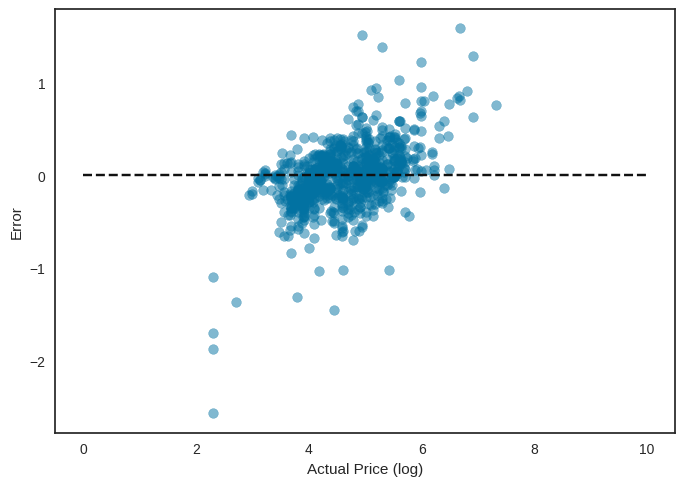

In [ ]:
#Find Errors by calculating the difference between the actual and predicted values
Errors=Y_test-rfm_test_preds

#Scatter plot between the Actual values and Error term
plt.scatter(Y_test, Errors, alpha=0.5)
plt.plot([0, 10], [0, 0], '--k')
plt.xlabel('Actual Price (log)')
plt.ylabel('Error')
plt.show()

## KNN 

In [82]:
# Handle nulls
# drop nulls, can handle a different way if needed, but we don't have many nulls
df_train_knn = df_train.dropna()
df_test_knn = df_test.dropna()
# df_train_knn = df_train
# df_test_knn = df_test
  

In [83]:
# impute missing values in X_train and X_test with respective column median in X_train
# for df1 in [df_train_knn, df_test_knn]:
#     for column in df_train_knn.columns:
#         col_median=df_train_knn[column].median()
#         df1[column].fillna(col_median, inplace=True) 

In [84]:
# get data ready for model inputs
exc =  ['intDailyPrice']

col = [i for i in col if i not in exc]
print('Number of columns is:', len(col))
print(col)


# standardize the data
scaler = StandardScaler()

X = scaler.fit_transform(df_train_knn[col])
X_test = scaler.transform(df_test_knn[col])
Y = df_train_knn['intDailyPrice']
Y_test = df_test_knn['intDailyPrice']

Number of columns is: 61
['boolInstantlyBookable', 'boolGuestProfilePicReqToBook', 'boolVerifiedGuestPhoneReqToBook', 'intDaysSinceFirstReview', 'intDaysSinceLastReview', 'intDaysSinceLastBookingCalendarUpdate', 'cintNeighborhood', 'cintZipCode', 'cintPropertyType', 'ointRoomType', 'cintBedType', 'cintCancelPolicy', 'intAccommodates', 'fltBathrooms', 'intGuestsIncluded', 'intMinNightsPerBooking', 'intMaxNightsPerBooking', 'intAvailDaysInNext30Days', 'intAvailDaysInNext365Days', 'intReviewScore', 'intCheckInReviewScore', 'intLocationReviewScore', 'intSameHostSameAreaListingsCount', 'intSameHostSameAreaPrivateRoomListingsCount', 'intSameHostSameAreaSharedRoomListingsCount', 'intSecurityDeposit', 'intExtraGuestsFee', 'intDaysHosting', 'boolHostListingNeighborhoodMatch', 'boolHostListingCityMatch', 'boolHostListingStateMatch', 'boolHostListingCountryMatch', 'ointHostResponseTime', 'fltHostResponseRate', 'fltHostAcceptanceRate', 'boolSuperhost', 'boolHostProfPicOnFile', 'boolHostIdentVerifi

In [85]:
# Begin with a trial value for K around 3
knn=KNeighborsRegressor(n_neighbors=3)
knn.fit(X,Y)
pred=knn.predict(X_test)

In [86]:
# prediction
knn_train_preds = knn.predict(X)
knn_test_preds = knn.predict(X_test)

# accuracy check
r2_train = r2_score(Y, knn_train_preds)
mse_train = mean_squared_error(knn_train_preds, Y)
rmse_train = sqrt(mean_squared_error(knn_train_preds, Y))
print('Train data accuracy')
print("R2: %.4f" % r2_train)
print("MSE: %.4f" % mse_train)
print("RMSE: %.2f" % rmse_train) 

r2_test = r2_score(Y_test, knn_test_preds)
mse_test = mean_squared_error(knn_test_preds, Y_test)
rmse_test = sqrt(mean_squared_error(knn_test_preds, Y_test))
print('Test data accuracy')
print("R2: %.4f" % r2_test)
print("MSE: %.4f" % mse_test)
print("RMSE: %.4f" % rmse_test) 

Train data accuracy
R2: 0.8263
MSE: 0.0956
RMSE: 0.31
Test data accuracy
R2: 0.6829
MSE: 0.1713
RMSE: 0.4139


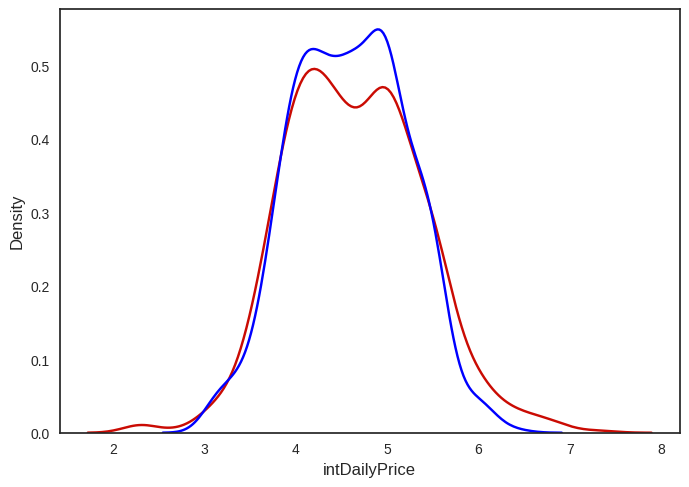

In [87]:
# Plotting the distribution plot
ax1=sns.distplot(Y_test,hist=False,color='r',label='actual value')
ax2=sns.distplot(pred,hist=False,color='blue',label='predicted value')

In [88]:
# Calculate RMSE for finding the optimal value of K
rmse=list()
rmse1=list()
new=list()
mylist=list(range(50))
mylist=list(filter(lambda x:x%2!=0,mylist))
for k in mylist:
    knn=KNeighborsRegressor(n_neighbors=k)
    knn.fit(X,Y)
    pred=knn.predict(X_test)
    pred1=knn.predict(X)
    error=sqrt(mean_squared_error(Y_test,pred)) 
    error1=sqrt(mean_squared_error(Y,pred1))
    rmse.append(error)
    new.append([error,k])
    rmse1.append(error1)
    print('RMSE test value for k= ' , k , 'is:', error, '\nRMSE train value for k is = ',error1)

RMSE test value for k=  1 is: 0.4765580154881263 
RMSE train value for k is =  0.0
RMSE test value for k=  3 is: 0.4138707488216207 
RMSE train value for k is =  0.3091830048149063
RMSE test value for k=  5 is: 0.4125421333315323 
RMSE train value for k is =  0.3490746432890736
RMSE test value for k=  7 is: 0.4155230462077162 
RMSE train value for k is =  0.37029123850674217
RMSE test value for k=  9 is: 0.41367589047424375 
RMSE train value for k is =  0.38363459501073854
RMSE test value for k=  11 is: 0.4105886986720935 
RMSE train value for k is =  0.3937816576057528
RMSE test value for k=  13 is: 0.41257334215224806 
RMSE train value for k is =  0.4007933699382637
RMSE test value for k=  15 is: 0.4153638317835969 
RMSE train value for k is =  0.406376730250411
RMSE test value for k=  17 is: 0.41793954882423867 
RMSE train value for k is =  0.40962646305453543
RMSE test value for k=  19 is: 0.4197931838013872 
RMSE train value for k is =  0.4142605713908367
RMSE test value for k=  2

In [89]:
# Creating a list of RMSE values
newList=list()
for x in mylist:
    newList.append(1/x)

In [90]:
# Finding the minimum RMSE for testing data,which is optimal K value
Rmsetest=min(new)
print("Minimum RMSE test error=",Rmsetest[0])
Rmsetrain=min(rmse1)
print("Minimum RMSE train error=",Rmsetrain)
print("Optimal K value= ",Rmsetest[1])

Minimum RMSE test error= 0.4105886986720935
Minimum RMSE train error= 0.0
Optimal K value=  11


Text(0, 0.5, 'RMSE test error')

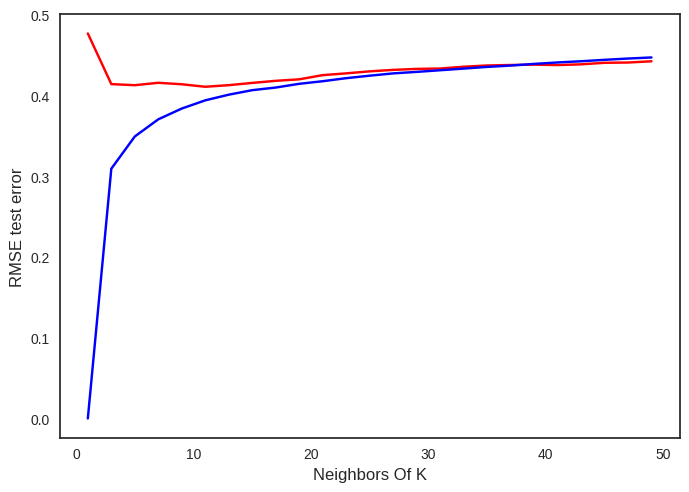

In [91]:
# Plot graph between RMSE value and K value
plt.plot(mylist,rmse,color='red')
plt.plot(mylist,rmse1,color='blue')
plt.xlabel('Neighbors Of K')
plt.ylabel('RMSE test error')

In [92]:
# find R2 with optimal K
knn_optimal=KNeighborsRegressor(n_neighbors=Rmsetest[1])
knn_optimal.fit(X,Y)

KNeighborsRegressor(n_neighbors=11)

In [93]:
# prediction
knn_train_preds = knn_optimal.predict(X)
knn_test_preds = knn_optimal.predict(X_test)

# accuracy check
r2_train = r2_score(Y, knn_train_preds)
mse_train = mean_squared_error(knn_train_preds, Y)
rmse_train = sqrt(mean_squared_error(knn_train_preds, Y))
print('Train data accuracy')
print("R2: %.4f" % r2_train)
print("MSE: %.4f" % mse_train)
print("RMSE: %.4f" % rmse_train) 

r2_test = r2_score(Y_test, knn_test_preds)
mse_test = mean_squared_error(knn_test_preds, Y_test)
rmse_test = sqrt(mean_squared_error(knn_test_preds, Y_test))
print('Test data accuracy')
print("R2: %.4f" % r2_test)
print("MSE: %.4f" % mse_test)
print("RMSE: %.4f" % rmse_test) 

Train data accuracy
R2: 0.7183
MSE: 0.1551
RMSE: 0.3938
Test data accuracy
R2: 0.6880
MSE: 0.1686
RMSE: 0.4106


## Extreme Gradient Boosting

In [ ]:
exc =  ['intDailyPrice']

col = [i for i in col if i not in exc]
print('Number of columns is:', len(col))
print(col)

X_train_df = df_train[col]
X_test_df = df_test[col]
Y_train_label = df_train['intDailyPrice']
Y_test_label = df_test['intDailyPrice']

dtrain = xgb.DMatrix(X_train_df, label=Y_train_label)
dtest = xgb.DMatrix(X_test_df, label=Y_test_label)

Number of columns is: 61
['boolInstantlyBookable', 'boolGuestProfilePicReqToBook', 'boolVerifiedGuestPhoneReqToBook', 'intDaysSinceFirstReview', 'intDaysSinceLastReview', 'intDaysSinceLastBookingCalendarUpdate', 'cintNeighborhood', 'cintZipCode', 'cintPropertyType', 'ointRoomType', 'cintBedType', 'cintCancelPolicy', 'intAccommodates', 'fltBathrooms', 'intGuestsIncluded', 'intMinNightsPerBooking', 'intMaxNightsPerBooking', 'intAvailDaysInNext30Days', 'intAvailDaysInNext365Days', 'intReviewScore', 'intCheckInReviewScore', 'intLocationReviewScore', 'intSameHostSameAreaListingsCount', 'intSameHostSameAreaPrivateRoomListingsCount', 'intSameHostSameAreaSharedRoomListingsCount', 'intSecurityDeposit', 'intExtraGuestsFee', 'intDaysHosting', 'boolHostListingNeighborhoodMatch', 'boolHostListingCityMatch', 'boolHostListingStateMatch', 'boolHostListingCountryMatch', 'ointHostResponseTime', 'fltHostResponseRate', 'fltHostAcceptanceRate', 'boolSuperhost', 'boolHostProfPicOnFile', 'boolHostIdentVerifi

In [ ]:
# Parameter dictionary specifying base learner
param = [('max_depth', 4), ('objective', 'reg:squarederror'), ('eval_metric', 'rmse'), ('eval_metric', 'mae'), ('eval_metric', 'mape'),
         ('early_stopping_rounds', 50)]

num_round = 500
watchlist = [(dtrain,'train'), (dtest,'eval')]

evals_result = {}
bst = xgb.train(param, dtrain, num_round, watchlist, evals_result=evals_result)

print('Access RMSE metric directly from evals_result:')
print(evals_result['eval']['rmse'])

print('Access MAE metric directly from evals_result:')
print(evals_result['eval']['mae'])

print('Access MAPE metric directly from evals_result:')
print(evals_result['eval']['mape'])

# Instantiate an XGBoost object with hyperparameters
param = [('max_depth', 4), ('objective', 'reg:squarederror'), ('eval_metric', 'rmse'), ('eval_metric', 'mae'), ('eval_metric', 'mape'),
         ('early_stopping_rounds', 50),('learning_rate', 0.1),('n_jobs',4),('booster','gbtree')]

num_round = 500
watchlist = [(dtrain,'train'), (dtest,'eval')]

evals_result = {}

[18:46:32] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	train-rmse:2.99087	train-mae:2.92276	train-mape:0.62067	eval-rmse:2.98247	eval-mae:2.91619	eval-mape:0.62070
[1]	train-rmse:2.12102	train-mae:2.04913	train-mape:0.43251	eval-rmse:2.11592	eval-mae:2.04672	eval-mape:0.43305
[2]	train-rmse:1.51935	train-mae:1.43816	train-mape:0.30131	eval-rmse:1.51638	eval-mae:1.43970	eval-mape:0.30271
[3]	train-rmse:1.10850	train-mae:1.01133	train-mape:0.20976	eval-rmse:1.10982	eval-mae:1.01818	eval-mape:0.21228
[4]	train-rmse:0.83285	train-mae:0.71768	train-mape:0.14719	eval-rmse:0.83563	eval-mae:0.72566	eval-mape:0.14979
[5]	train-rmse:0.65320	train-mae:0.52547	train-mape:0.10683	eval-rmse:0.65631	eval-mae:0.53469	eval-mape:0.10950
[6]	train-rmse:0.53980	train-mae:0.40869	train-mape:0.08317	eval-rmse:0.54385	eval-mae:0.41729	eval-mape:0.08557


/usr/local/lib/python3.9/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[7]	train-rmse:0.47179	train-mae:0.34396	train-mape:0.07065	eval-rmse:0.47756	eval-mae:0.35569	eval-mape:0.07373
[8]	train-rmse:0.43160	train-mae:0.30766	train-mape:0.06391	eval-rmse:0.43889	eval-mae:0.32035	eval-mape:0.06723
[9]	train-rmse:0.40797	train-mae:0.28906	train-mape:0.06080	eval-rmse:0.41529	eval-mae:0.30028	eval-mape:0.06374
[10]	train-rmse:0.39324	train-mae:0.27854	train-mape:0.05916	eval-rmse:0.40126	eval-mae:0.28805	eval-mape:0.06172
[11]	train-rmse:0.38515	train-mae:0.27308	train-mape:0.05843	eval-rmse:0.39356	eval-mae:0.28116	eval-mape:0.06062
[12]	train-rmse:0.37840	train-mae:0.26798	train-mape:0.05757	eval-rmse:0.38887	eval-mae:0.27748	eval-mape:0.06003
[13]	train-rmse:0.37229	train-mae:0.26336	train-mape:0.05678	eval-rmse:0.38369	eval-mae:0.27221	eval-mape:0.05909
[14]	train-rmse:0.36779	train-mae:0.26094	train-mape:0.05637	eval-rmse:0.38052	eval-mae:0.26954	eval-mape:0.05860
[15]	train-rmse:0.36475	train-mae:0.25894	train-mape:0.05607	eval-rmse:0.37878	eval-mae:0.2

/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



In Sample RMSE:  0.3406

In Sample R-Squared:  0.8024

Out of Sample RMSE:  0.3574

Out of Sample R-Squared:  0.7768

Prediction Error Plot


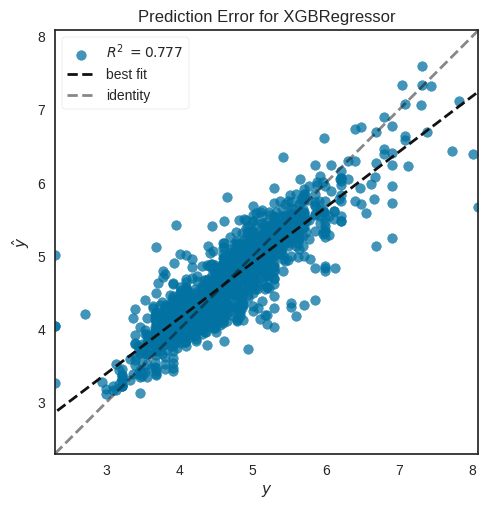

PredictionError(ax=<Axes: title={'center': 'Prediction Error for XGBRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>,
                estimator=XGBRegressor(base_score=None, booster='gbtree',
                                       callbacks=None, colsample_bylevel=None,
                                       colsample_bynode=None,
                                       colsample_bytree=None,
                                       early_stopping_rounds=None,
                                       enable_categorical=False,
                                       eval_metric=None, feature_types=None,
                                       gamma=None, gpu_...
                                       grow_policy=None, importance_type=None,
                                       interaction_constraints=None,
                                       learning_rate=0.001, max_bin=None,
                                       max_cat_threshold=None,
                                       max_cat_to_one

In [ ]:

xgb_reg = xgb.XGBRegressor(max_depth=2, n_estimators=50000, n_jobs=4,
                           objectvie='reg:squarederror', verbosity = 0,silent=True,
                           booster='gbtree', random_state=42, learning_rate=0.001)

# Train the model with train data sets
xgb_reg.fit(X_train_df, Y_train_label,
            eval_set=[(X_train_df, Y_train_label), (X_test_df, Y_test_label)],
            early_stopping_rounds=100, verbose=0)

y_train_pred = xgb_reg.predict(X_train_df) # Predictions
y_train_true = Y_train_label # True values

Train_MSE = mean_squared_error(y_train_true, y_train_pred)
Train_RMSE = np.sqrt(Train_MSE)

Train_R_squared = r2_score(y_train_true, y_train_pred)

print("\nIn Sample RMSE: ", np.round(Train_RMSE, 4))
print()
print("In Sample R-Squared: ", np.round(Train_R_squared, 4))

y_test_pred = xgb_reg.predict(X_test_df) # Predictions
y_test_true = Y_test_label # True values

Test_MSE = mean_squared_error(y_test_true, y_test_pred)
Test_RMSE = np.sqrt(Test_MSE)

Test_R_squared = r2_score(y_test_true, y_test_pred)

print("\nOut of Sample RMSE: ", np.round(Test_RMSE, 4))
print()
print("Out of Sample R-Squared: ", np.round(Test_R_squared, 4))

# Making the Prediction Error Plot
print("\nPrediction Error Plot")
print(prediction_error(xgb_reg, X_train_df, Y_train_label, X_test_df, Y_test_label))

# Making the Residuals Plot
# print("\nResiduals Plot")
# print(residuals_plot(xgb_reg, X_train_df, Y_train_label, X_test_df, Y_test_label))


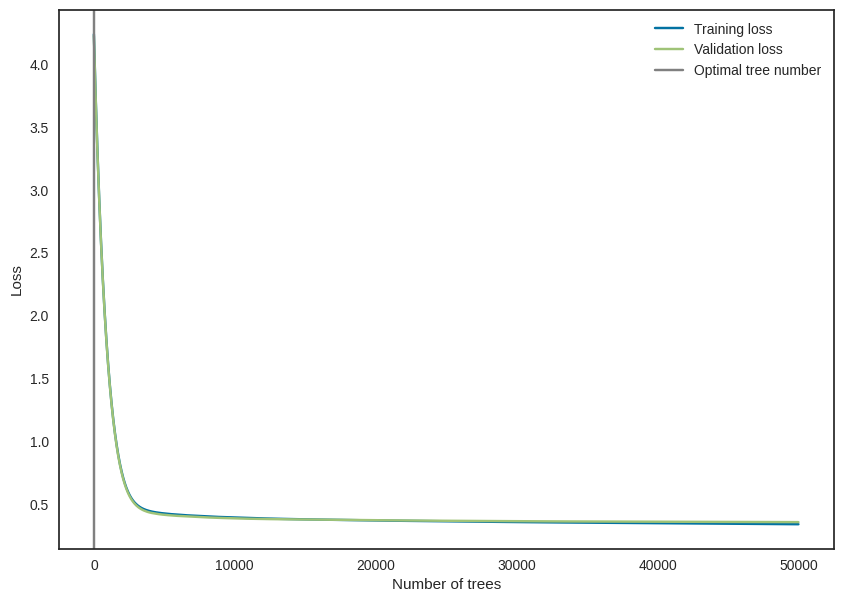

In [ ]:
results = xgb_reg.evals_result()

plt.figure(figsize=(10,7))
plt.plot(results["validation_0"]["rmse"], label="Training loss")
plt.plot(results["validation_1"]["rmse"], label="Validation loss")
plt.axvline(21, color="gray", label="Optimal tree number")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()

In [ ]:
xgb2 = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.8,
             colsample_bynode=0.6, colsample_bytree=0.2, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.001, max_delta_step=0, max_depth=14,
             min_child_weight=14, monotone_constraints='()',
             n_estimators=100000, n_jobs=36, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

# Train the model with train data sets
xgb2.fit(X_train_df, Y_train_label,
            eval_set=[(X_train_df, Y_train_label), (X_test_df, Y_test_label)],
            early_stopping_rounds=1000, verbose=1000)

y_train_pred = xgb2.predict(X_train_df) # Predictions
y_train_true = Y_train_label # True values

Train_MSE = mean_squared_error(y_train_true, y_train_pred)
Train_RMSE = np.sqrt(Train_MSE)

Train_R_squared = r2_score(y_train_true, y_train_pred)

print("\nIn Sample RMSE: ", np.round(Train_RMSE, 4))
print()
print("In Sample R-Squared: ", np.round(Train_R_squared, 4))

y_test_pred = xgb2.predict(X_test_df) # Predictions
y_test_true = Y_test_label # True values

Test_MSE = mean_squared_error(y_test_true, y_test_pred)
Test_RMSE = np.sqrt(Test_MSE)

Test_R_squared = r2_score(y_test_true, y_test_pred)

print("\nOut of Sample RMSE: ", np.round(Test_RMSE, 4))
print()
print("Out of Sample R-Squared: ", np.round(Test_R_squared, 4))

[0]	validation_0-rmse:4.23747	validation_1-rmse:4.22505


/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


28738


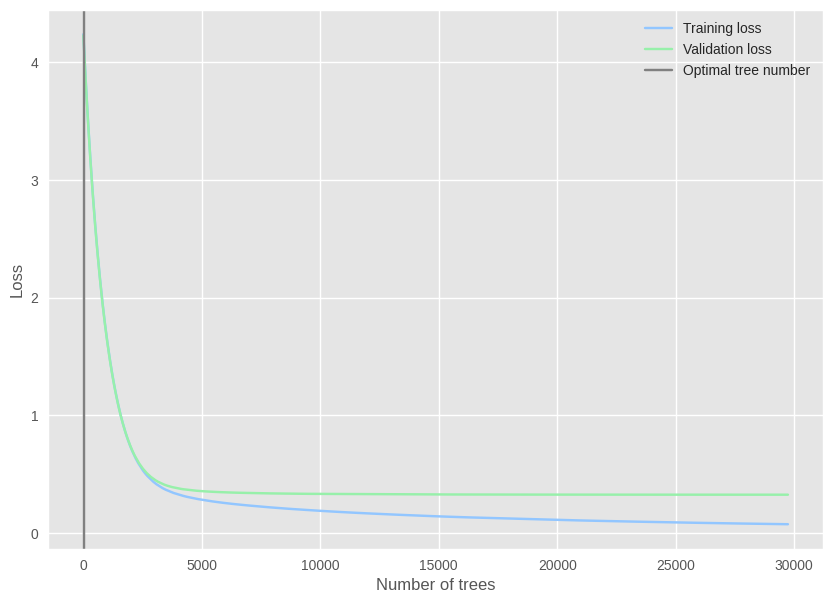

In [ ]:
results = xgb2.evals_result()

plt.figure(figsize=(10,7))
plt.plot(results["validation_0"]["rmse"], label="Training loss")
plt.plot(results["validation_1"]["rmse"], label="Validation loss")
plt.axvline(21, color="gray", label="Optimal tree number")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()

print(xgb2.best_ntree_limit)

XGB GS

In [ ]:
# create a baseline
booster = xgb.XGBRegressor()

In [ ]:
# create Grid of parameters
param_grid = {'n_estimators': [100, 150, 200],
              'learning_rate': [0.01, 0.05, 0.1], 
              'max_depth': [3, 4, 5, 6, 7],
              'colsample_bytree': [0.6, 0.7, 1],
              'gamma': [0.0, 0.1, 0.2]}

# instantiate the tuned random forest
booster_grid_search = GridSearchCV(booster, param_grid, cv=3)

# train the tuned random forest
booster_grid_search.fit(X_train_df, Y_train_label)

# print best estimator parameters found during the grid search
print(booster_grid_search.best_params_)

# {'colsample_bytree': 0.6, 'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 200}

{'colsample_bytree': 0.6, 'gamma': 0.2, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 200}


In [ ]:
# instantiate xgboost with the most optimal parameters
booster = xgb.XGBRegressor(colsample_bytree=0.6, gamma=0.1, learning_rate=0.05, 
                           max_depth=7, n_estimators=200)

# train the model
booster.fit(X_train_df, Y_train_label)

# predict the values
y_pred_train = booster.predict(X_train_df)
y_pred_test = booster.predict(X_test_df)

In [ ]:
print("Training Results:")
RMSE = np.sqrt(mean_squared_error(Y_train_label, y_pred_train))
r2 = r2_score(Y_train_label, y_pred_train)
print(f"RMSE: {round(RMSE, 5)}")
print(f"r2: {round(r2, 5)}")

print("Testing Results:")
RMSE = np.sqrt(mean_squared_error(Y_test_label, y_pred_test))
r2 = r2_score(Y_test_label, y_pred_test)
print(f"RMSE: {round(RMSE, 5)}")
print(f"r2: {round(r2, 5)}")

Training Results:
RMSE: 0.20395
r2: 0.92915
Testing Results:
RMSE: 0.33446
r2: 0.8045
